### Wrinkle Detection
#### U-net w. f-1 loss
* https://datalab.snu.ac.kr/datalab-internal/gpu-status/
* warhol2
  * `jupyter lab --ip=147.46.216.82 --NotebookApp.password='sha1:6d8bb616ac21:dc1b7ebffd85cb159379a282c6b49e6121e0ffb1'`
* warhol4 `http://147.46.215.47:8011/`

In [24]:
import torch
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memoy_cached())

4
GeForce GTX 1080 Ti
True


In [25]:
import argparse

import os
import csv
import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import plot_metric
from unet.model import UNet
from unet.dataset import *
from unet.util import *
from unet.train import train
from unet.evaluate import evaluate
from unet.loss import f1_loss, weighted_loss_and_f1_loss

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import transforms, datasets

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
def print_log(machine, key, lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue):
    time = datetime.datetime.today()
    time = time.strftime('%m-%d_%H-%M')
    time_and_key_and_loss = time + "_" + key + '_'+ loss_name
    time_and_key_and_loss = machine + "_" + key + '_'+ loss_name
    
    if ckpt_dir == "./checkpoint":
        ckpt_dir = os.path.join(ckpt_dir, time_and_key_and_loss)
    log_dir = os.path.join(log_dir, time_and_key_and_loss)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        
    print(f'tensorboard --logdir {log_dir} --host "147.46.215.47" --port 6006')
    
    # log parameters
    print("learning rate: %.4e" % lr)
    print("batch size: %d" % batch_size)
    print("number of epoch: %d" % num_epoch)
    print("loss function : %s" % loss_name)
    print("data dir: %s" % data_dir)
    print("ckpt dir: %s" % ckpt_dir)
    print("log dir: %s" % log_dir)
    print("mode: %s" % mode)
    print("device: %s" % device)
    print("train_continue: %s" % train_continue)
    f = open(os.path.join(log_dir, 'parameter.txt'), 'w')
    f.write("learning rate: %.4e\n" % lr)
    f.write("batch size: %d\n" % batch_size)
    f.write("number of epoch: %d\n" % num_epoch)
    f.write("loss function : %s\n" % loss_name)
    f.write("data dir: %s\n" % data_dir)
    f.write("ckpt dir: %s\n" % ckpt_dir)
    f.write("log dir: %s\n" % log_dir)
    f.write("mode: %s\n" % mode)
    f.write("device: %s\n" % device)
    f.write("train_continue: %s\n" % train_continue)
    f.close()
    return ckpt_dir, log_dir

In [28]:
def train_unet(data_dir, loss_name='weighted_BCE', lr=1e-3, batch_size=8, num_epoch=300, ckpt_dir="./checkpoint", log_dir="./log", mode="train", train_continue="off", key='eye_left', machine='warhol1'):
    train_transform = transforms.Compose([RandomRotation(max_degree=30), RandomResizedCrop(ratio=0.3), Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
    val_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

    dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

    dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=val_transform)
    loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

    num_data_train = len(dataset_train)
    num_data_val = len(dataset_val)

    num_batch_train = np.ceil(num_data_train / batch_size)
    num_batch_val = np.ceil(num_data_val / batch_size)

    
    if loss_name == "BCE":
        loss_function = nn.BCEWithLogitsLoss().to(device)
    elif loss_name == "weighted_BCE":
        loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5])).to(device)  # 237 - > 59 -> 15
    elif loss_name == "f1":
        loss_function = f1_loss
    elif loss_name =="mix":
        mix_class = weighted_loss_and_f1_loss(nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5])).to(device))
        loss_function = mix_class.loss
    else:
        assert False, loss_name + " is not supported"
        
    ckpt_dir, log_dir = print_log(machine, key, lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue)
        
    net = UNet()
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)
    
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[40, 70, 90], gamma=0.5)


    writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
    writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

    train_f = open(os.path.join(log_dir, 'train.tsv'), 'w', encoding='utf-8', newline='')
    train_wr = csv.writer(train_f, delimiter='\t')
    val_f = open(os.path.join(log_dir, 'val.tsv'), 'w', encoding='utf-8', newline='')
    val_wr = csv.writer(val_f, delimiter='\t')
    train_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])
    val_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])

    ## train network
    st_epoch = 0

    if train_continue == "on":
        net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    for epoch in range(st_epoch, st_epoch + num_epoch):
        net.train()
        loss, acc, f1, tp, tn, fp, fn = train(net, loader_train, loss_function, num_batch_train, epoch, writer_train, device, optim)
        train_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))

        loss, acc, f1, tp, tn, fp, fn = evaluate(net, loader_val, loss_function, num_batch_val, epoch, writer_val, device)
        val_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))
        
        scheduler.step()
        
        if epoch+1 == num_epoch: #((epoch+1) % (num_epoch / 10)) == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch+1)
        print("------------------------------------------------------------")

    writer_train.close()
    writer_val.close()
    train_f.close()
    val_f.close()
    
    return ckpt_dir, log_dir

In [29]:
machine = 'warhol1'
loss = 'f1'

ckpts = {}
logs = {}

face_dict = {
    'eye_left': (0, 575, 220, 603),
    'eye_right': (672, 1247, 220, 603),
    'nose_left': (350, 573, 400, 943),
    'nose_right': (700, 923, 400, 943),
    'mouth': (300, 971, 940, 1195),
    'forehead': (0, 1247, 0, 223),
    'cheek_right': (896, 1247, 576, 1343),
    'cheek_left': (0, 351, 576, 1343),
    'jaw': (350, 925, 1152, 1343),
    'center': (550, 709, 220, 955)
}

# for key in face_dict:
#     new_logs = {}
#     new_ckpts = {}
#     new_ckpts[loss], new_logs[loss] = train_unet(f"../data/split_data/{key}/", loss, num_epoch=200, batch_size=16, key=key, machine=machine)
#     ckpts[key], logs[key] = new_ckpts, new_logs

In [30]:
for key in face_dict:
    new_ckpt = {}
    new_log = {}
    
    machine = 'warhol1'
    loss = 'f1'
    new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
    machine = 'warhol4'
    loss = 'weighted_BCE'
    new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
    ckpts[key], logs[key] = new_ckpt, new_log

In [31]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0)

def f1_score(y_pred, y_true):
    eps = np.finfo(np.float64).eps

    tp = np.sum(y_true*y_pred)
    tn = np.sum((1-y_true)*(1-y_pred))
    fp = np.sum((1-y_true)*y_pred)
    fn = np.sum(y_true*(1-y_pred))

    p = (tp) / (tp + fp + eps)
    r = (tp) / (tp + fn + eps)
    f1 = 2*p*r / (p + r + eps)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)
    return tp, tn, fp, fn, f1

def load(ckpt_dir, net, ckpt_name=None):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        print("ckpt_dir : ", ckpt_dir)
        print("ckpt_name : ", ckpt_name)
        print("failed to load model")
        return None

    if ckpt_name == None:
        ckpt_lst = os.listdir(ckpt_dir)
        ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        ckpt_name = ckpt_lst[-1]

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_name))

    net.load_state_dict(dict_model['net'])

    return net

def merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, coordinates, h=1344, w=1248, included_parts=[]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time = datetime.datetime.today()
    time = time.strftime('%m-%d_%H-%M')
    keys = list(coordinates.keys())

    result_dir = result_dir + time + "/"
    if not os.path.exists(result_dir):
        os.makedirs(os.path.join(result_dir, 'png'))

    orig_data_dir = os.path.join(orig_data_dir, 'val')
    sample_data_dir = os.path.join(split_data_dir, keys[0], 'val')
    image_list = os.listdir(sample_data_dir)
    image_list = [img_file_name for img_file_name in image_list if img_file_name.endswith(".jpg")]
    image_num = len(image_list)

    pred_result = np.zeros((image_num, 1344, 1248))
    
    f = open(os.path.join(result_dir, 'log.txt'), 'w')
    
    transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
    
    for key in keys:
        if key not in included_parts and len(included_parts) is not 0:
            continue
        data_key_dir = os.path.join(split_data_dir, key, 'val')
        coord = coordinates[key]
        x1, x2, y1, y2 = coord
        ckpt_dir = ckpt_dirs[key]
        net = UNet()
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
        net.to(device)
        print("loading from ", ckpt_dir, "...")
        net = load(ckpt_dir=ckpt_dir, net=net)
        if net is None:
            continue
        dataset_test = Dataset(data_key_dir, transform=transform)
        loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1)
        
        with torch.no_grad():
            net.eval()
            
            for index, data in enumerate(loader_test):
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)
                # N x H x W x C
                pred = fn_tonumpy(fn_class(output))
                pred_result[index, y1:y2+1, x1:x2+1] = np.logical_or(pred_result[index, y1:y2+1, x1:x2+1],pred[0].squeeze())
                

        del net
        del dataset_test
        del loader_test
    
#     lable_list = os.listdir(orig_data_dir)
#     lable_list = [label_file_name for label_file_name in lable_list if label_file_name.endswith(".npy")]
#     lable_list = sorted(lable_list)
#     f1_arr = []
#     for i in range(image_num):
#         label = np.load(os.path.join(orig_data_dir, lable_list[i]))
#         tp, tn, fp, fn, f1 = f1_score(pred_result[i], label)
#         print("TEST: BATCH %04d / %04d | F1 SCORE %.4F" %
#                     (i+1, image_num, f1))
#         f.write("TEST: BATCH %04d / %04d | F1 SCORE %.4F\n" %
#                     (i+1, image_num, f1))
#         f1_arr.append(f1)
#         plt.imsave(os.path.join(result_dir, 'png', '%04d_output.png' % i), pred_result[i], cmap='gray')
#         plt.imsave(os.path.join(result_dir, 'png', '%04d_label.png' % i), label, cmap='gray')
#     print("AVERAGE TEST: TOTAL IMAGES : %04d | F1 SCORE %.4F" %
#                     (image_num, np.mean(f1_arr)))
#     f.write("AVERAGE TEST: TOTAL IMAGES : %04d | F1 SCORE %.4F\n" %
#                     (image_num, np.mean(f1_arr)))
    return pred_result
        

In [32]:
ckpt_dirs = {}
(split_data_dir, orig_data_dir, result_dir)  = ("../data/split_data/", "../data/final_data", f"./result/")
for key in ckpts:
    ckpt_dirs[key] = ckpts[key]['f1']
f1_pred_result = merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, face_dict)
for key in ckpts:
    ckpt_dirs[key] = ckpts[key]['weighted_BCE']
wbce_pred_result = merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, face_dict)

loading from  ./checkpoint/warhol1_eye_left_f1 ...
loading from  ./checkpoint/warhol1_eye_right_f1 ...
loading from  ./checkpoint/warhol1_nose_left_f1 ...
loading from  ./checkpoint/warhol1_nose_right_f1 ...
loading from  ./checkpoint/warhol1_mouth_f1 ...
loading from  ./checkpoint/warhol1_forehead_f1 ...
loading from  ./checkpoint/warhol1_cheek_right_f1 ...
loading from  ./checkpoint/warhol1_cheek_left_f1 ...
loading from  ./checkpoint/warhol1_jaw_f1 ...
loading from  ./checkpoint/warhol1_center_f1 ...
loading from  ./checkpoint/warhol4_eye_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_eye_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_nose_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_nose_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_mouth_weighted_BCE ...
loading from  ./checkpoint/warhol4_forehead_weighted_BCE ...
loading from  ./checkpoint/warhol4_cheek_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_cheek_left_weighted_BCE .

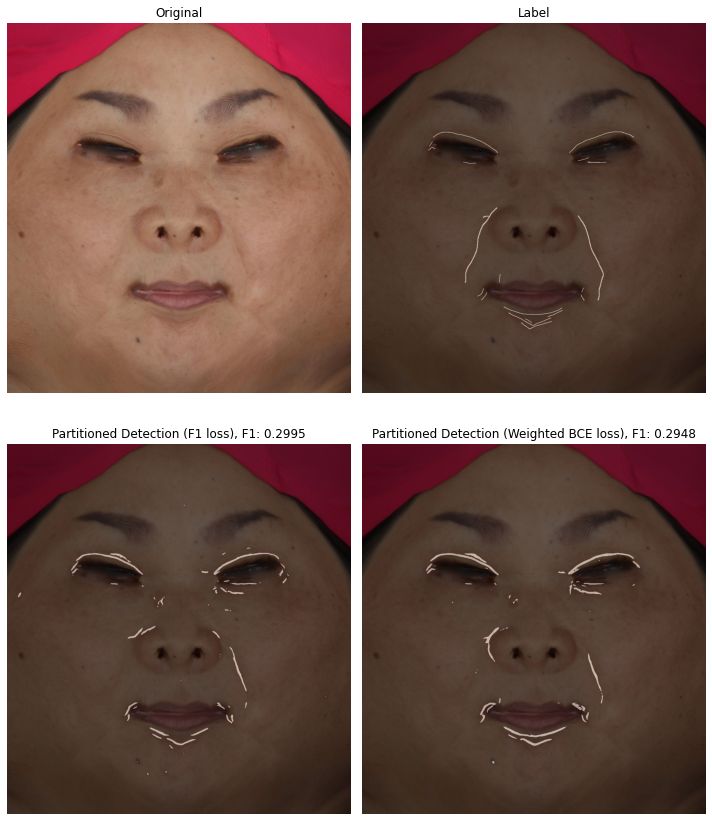

In [18]:

keys = list(face_dict.keys())
orig_data_dir = os.path.join("../data/final_data", 'val')
sample_data_dir = os.path.join("../data/split_data/", keys[0], 'val')
image_list = os.listdir(sample_data_dir)
image_list = [img_file_name for img_file_name in image_list if img_file_name.endswith(".jpg")]
image_list = sorted(image_list)
image_num = len(image_list)

lable_list = os.listdir(orig_data_dir)
lable_list = [label_file_name for label_file_name in lable_list if label_file_name.endswith(".npy")]
lable_list = sorted(lable_list)

for i in range(image_num):
    label = np.load(os.path.join(orig_data_dir, lable_list[i]))
    image = plt.imread(os.path.join(orig_data_dir, image_list[i]))
    tp, tn, fp, fn, f1_f1 = f1_score(f1_pred_result[i], label)
    tp, tn, fp, fn, f1_wbce = f1_score(wbce_pred_result[i], label)
    
    np.ma.masked_where(label > 0, label)
    np.ma.masked_where(f1_pred_result[i] > 0, f1_pred_result[i])
    np.ma.masked_where(wbce_pred_result[i] > 0, wbce_pred_result[i])
    
    plt.close()
    fig, axes = plt.subplots(2, 2, figsize=(10, 12))
    axes[0][0].axis('off')
    axes[0][0].set_title("Original")
    axes[0][1].axis('off')
    axes[0][1].set_title("Label")
    
    axes[0][0].imshow(image)
    axes[0][1].imshow(image)
    axes[0][1].imshow(label, 'gray', alpha=0.5)
    
    axes[1][0].axis('off')
    axes[1][0].set_title(f"Partitioned Detection (F1 loss), F1: {np.round(f1_f1, 4)}")
    axes[1][1].axis('off')
    axes[1][1].set_title(f"Partitioned Detection (Weighted BCE loss), F1: {np.round(f1_wbce, 4)}")
    
    axes[1][0].imshow(image)
    axes[1][0].imshow(f1_pred_result[i], 'gray', alpha=0.5)
    axes[1][1].imshow(image)
    axes[1][1].imshow(wbce_pred_result[i], 'gray', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'result/00-comparison/{os.path.splitext(lable_list[i])[0]}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    break
    

In [16]:
def my_plot(ax, d, included_parts=[]):
    for key in d:
        if key not in included_parts:
            continue
        (x1, x2, y1, y2) = d[key]
        if key is 'forehead':
            ax.text(x1+10, y1+50, key, color='y', fontsize=12)
        else:
            ax.text(x1, y1-10, key, color='y', fontsize=12)
        ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='y', facecolor='none'))

0005_f_45_08_mouth_left_tex.npy 0005_f_45_08_mouth_left_tex.jpg
['eye_left']
loading from  ./checkpoint/warhol4_eye_left_weighted_BCE ...


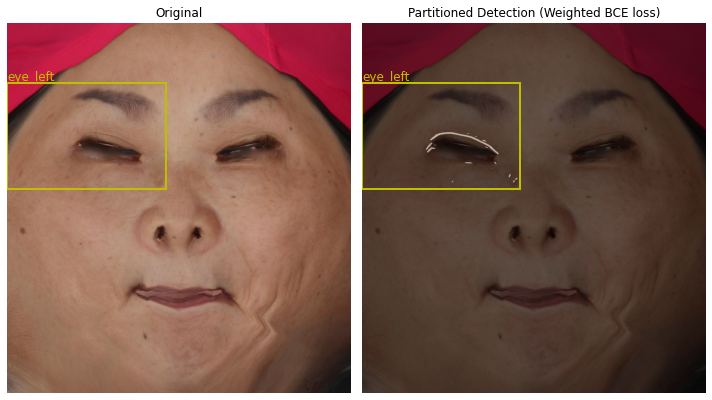

['eye_left', 'eye_right']
loading from  ./checkpoint/warhol4_eye_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_eye_right_weighted_BCE ...


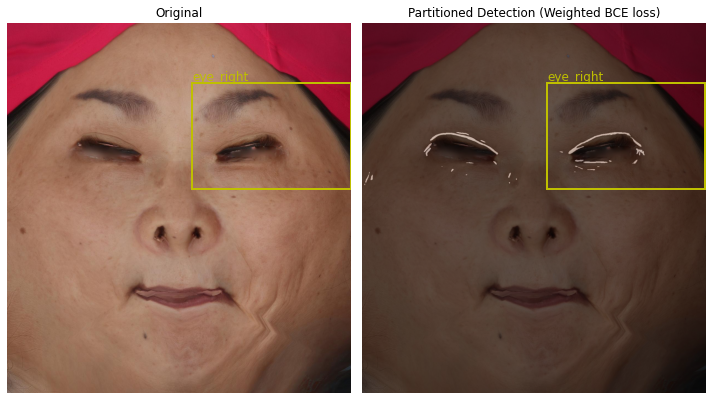

['eye_left', 'eye_right', 'nose_left']
loading from  ./checkpoint/warhol4_eye_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_eye_right_weighted_BCE ...


KeyboardInterrupt: 

In [21]:
idx = 6
print(lable_list[idx], image_list[idx])
label = np.load(os.path.join(orig_data_dir, lable_list[idx]))
image = plt.imread(os.path.join(orig_data_dir, image_list[idx]))
for i in range(len(keys)):
    included_parts = keys[0:i+1]
    print(included_parts)
    for key in ckpts:
        ckpt_dirs[key] = ckpts[key]['weighted_BCE']
    wbce_pred_result = merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, face_dict, included_parts=included_parts)
    
    np.ma.masked_where(wbce_pred_result[i] > 0, wbce_pred_result[i])
    
    plt.close()
    fig, axes = plt.subplots(1, 2, figsize=(10, 12))
    axes[0].axis('off')
    axes[0].set_title("Original")
    axes[0].imshow(image)
    my_plot(axes[0], face_dict, keys[i])

    axes[1].axis('off')
    axes[1].set_title(f"Partitioned Detection (Weighted BCE loss)")
    axes[1].imshow(image)
    axes[1].imshow(wbce_pred_result[i], 'gray', alpha=0.5)
    my_plot(axes[1], face_dict, keys[i])
    plt.tight_layout()
    plt.savefig(f'result/01-partition/{i}-{keys[i]}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

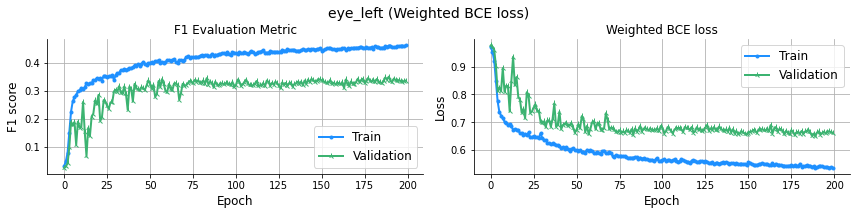

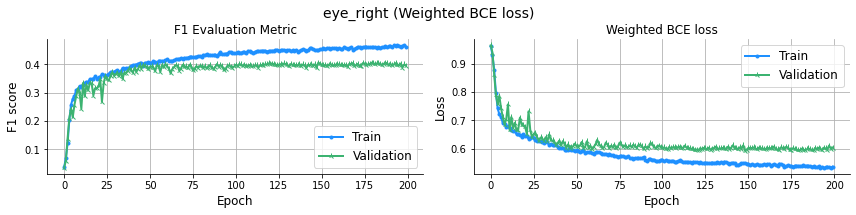

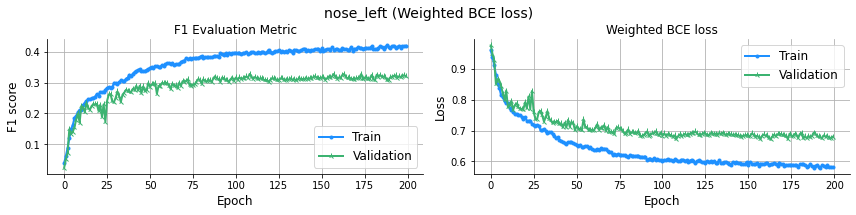

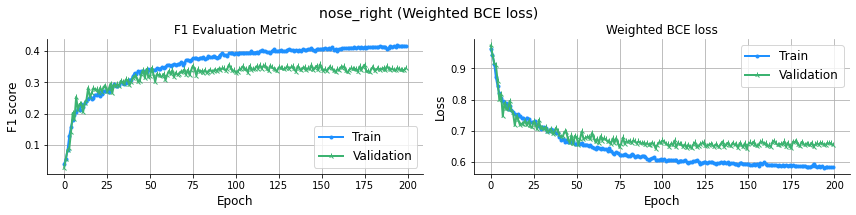

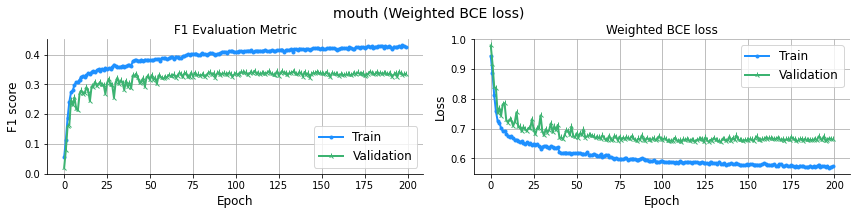

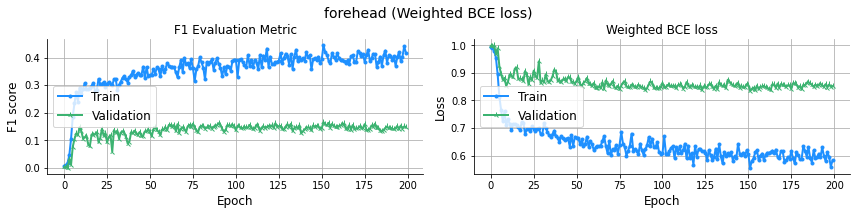

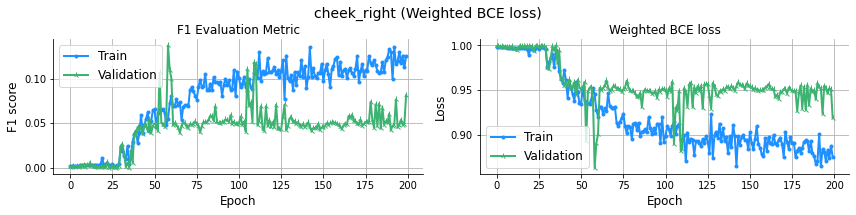

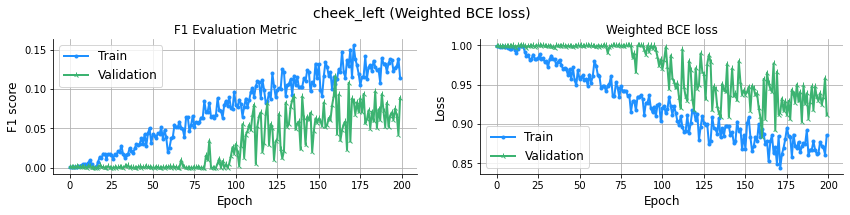

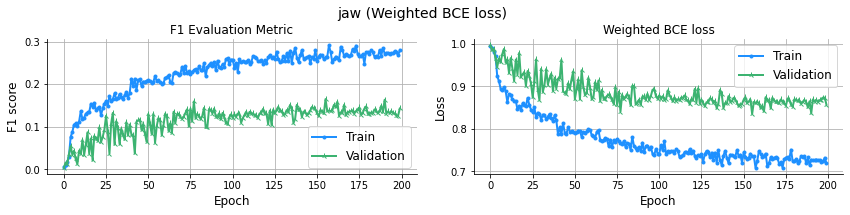

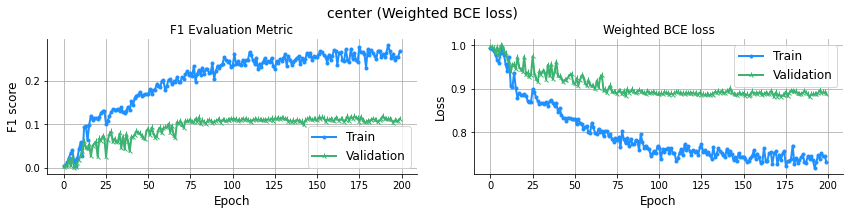

In [185]:
import pandas as pd

markers = (".", "2", "s", "^")
colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')

i = 0
for key in face_dict:
    new_ckpt = {}
    new_log = {}
    
    machine = 'warhol1'
    loss = 'f1'
    new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
#     machine = 'warhol4'
#     loss = 'weighted_BCE'
#     new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
    plt.close()
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.color'] = 'r'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # epoch/loss/acc/f1/tp/tn/fp/fn
    df = pd.read_csv(f"{new_log[loss]}/val.tsv", delimiter='\t', header=None, skiprows=1)
    val = df[3].to_numpy()
    df = pd.read_csv(f"{new_log[loss]}/train.tsv", delimiter='\t', header=None, skiprows=1)
    train = df[3].to_numpy()
    
    axes[0].plot(train, color=colors[0], marker=markers[0])
    axes[0].plot(val, color=colors[1], marker=markers[1])
    axes[0].legend(['Train', 'Validation'], fontsize=12)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('F1 score', fontsize=12)
    axes[0].set_title(f'F1 Evaluation Metric', fontsize=12)

    # epoch/loss/acc/f1/tp/tn/fp/fn
    df = pd.read_csv(f"{new_log[loss]}/val.tsv", delimiter='\t', header=None, skiprows=1)
    val = df[1].to_numpy()
    df = pd.read_csv(f"{new_log[loss]}/train.tsv", delimiter='\t', header=None, skiprows=1)
    train = df[1].to_numpy()
    
    axes[1].plot(train, color=colors[0], marker=markers[0])
    axes[1].plot(val, color=colors[1], marker=markers[1])
    axes[1].legend(['Train', 'Validation'], fontsize=12)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title(f'Weighted BCE loss', fontsize=12)
#     axes[1].set_title(f'F1 loss', fontsize=12)
    
    plt.suptitle(f'{key} (Weighted BCE loss)', fontsize=14)
#     plt.suptitle(f'{key} (F1 loss)', fontsize=14)
    plt.tight_layout()
    fig.subplots_adjust(top=0.83)
    plt.savefig(f'result/02-loss-f1-plot/wbce-{i}-{key}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
#     plt.savefig(f'result/02-loss-f1-plot/f1-{i}-{key}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    i += 1